In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

In [8]:
train_dataset = pd.read_csv('train.csv')
valid_dataset = pd.read_csv('valid.csv')
test_dataset = pd.read_csv('test.csv')

# Label 2

In [9]:
label_2_train_ori = train_dataset.drop(columns=['label_1','label_3','label_4']).dropna()
label_2_valid_ori = valid_dataset.drop(columns=['label_1','label_3','label_4']).dropna()

## Handle class imbalances

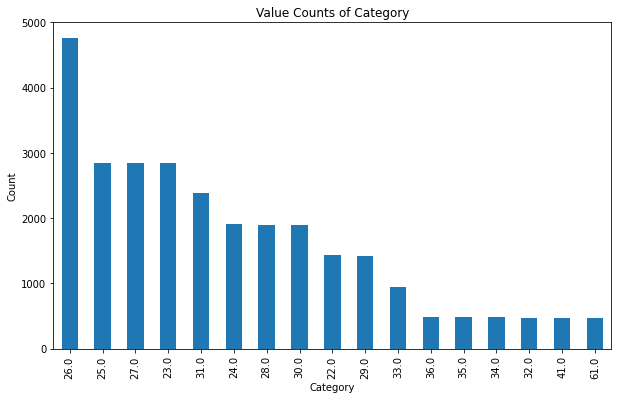

In [10]:
value_counts = label_2_train_ori['label_2'].value_counts()
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Value Counts of Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

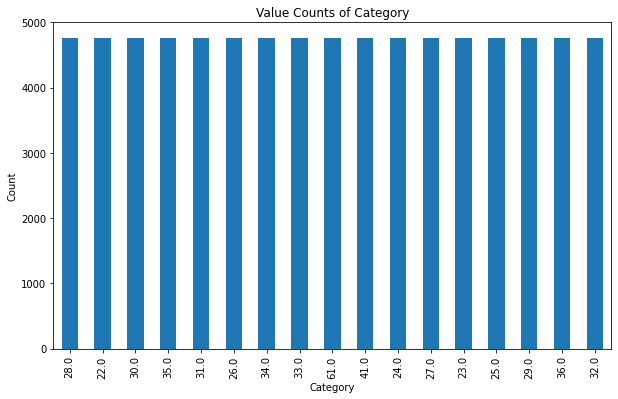

In [11]:
label_2_train_X = label_2_train_ori.drop(columns=['label_2'])
label_2_train_y = label_2_train_ori['label_2']
label_2_valid_X = label_2_valid_ori.drop(columns=['label_2'])
label_2_valid_y = label_2_valid_ori['label_2']


ros = RandomOverSampler(random_state=44)
X_resampled_label_2, y_resampled_label_2 = ros.fit_resample(label_2_train_X, label_2_train_y)
value_counts = y_resampled_label_2.value_counts()
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Value Counts of Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(label_2_train_X)
X_valid_scaled = scaler.transform(label_2_valid_X)

## Without any Tuning

In [18]:
clf = SVC(kernel='rbf')
clf.fit(X_train_scaled,label_2_train_y)
predictions_label_2 = clf.predict(X_valid_scaled)
initial_accuracy = accuracy_score(label_2_valid_y, predictions_label_2)
print(f"Accuracy: {initial_accuracy*100:.2f}%")

Accuracy: 93.89%


## PCA Analysis

In [19]:
pca = PCA(n_components=0.97,svd_solver='full')
principal_components_label_2 = pca.fit_transform(X_train_scaled)
valid_principal_components_label_2 = pca.transform(X_valid_scaled)

principal_df_label_2 = pd.DataFrame(data=principal_components_label_2, columns=[f'new_feature_{i}' for i in range(principal_components_label_2.shape[1])])
valid_principal_df_label_2 = pd.DataFrame(data = valid_principal_components_label_2,columns=[f'new_feature_{i}' for i in range(valid_principal_components_label_2.shape[1])])

## Hyperparameter Tuning

In [23]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
                'C': [1, 10, 20, 30, 40, 50, 100],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'gamma': ['scale', 'auto']
                }

base_estimator = SVC(gamma='scale', kernel='rbf', random_state=42)
search = HalvingGridSearchCV(base_estimator, param_grid, cv=5, verbose=1, n_jobs=7)
search.fit(principal_df_label_2, label_2_train_y)

print(search.best_params_)
print(search.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1038
max_resources_: 28040
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 56
n_resources: 1038
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 1
n_candidates: 19
n_resources: 3114
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 2
n_candidates: 7
n_resources: 9342
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 3
n_candidates: 3
n_resources: 28026
Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}
0.6390008920606601


In [24]:
y_pred_label_2 = search.best_estimator_.predict(valid_principal_df_label_2)
accuracy_tuned = accuracy_score(y_pred_label_2, label_2_valid_y)
print(f"Accuracy on validation data: {accuracy_tuned * 100:.2f}%")

Accuracy on validation data: 95.24%


In [26]:
label_2_data_to_predict = test_dataset.drop(columns=['ID'])
scaled_test_label_2 = scaler.transform(label_2_data_to_predict)
pca_reduced_label_2 = pca.transform(scaled_test_label_2)
final_label_2_predict = search.best_estimator_.predict(pca_reduced_label_2)

c:\Users\Wenuka\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [27]:
final_submission = "190601D_submission1.csv"
dataframe = pd.read_csv(final_submission)
dataframe['label_2'] = final_label_2_predict
dataframe.to_csv(final_submission,index=False)